In [40]:
import torch
import torchvision

from datasets import load_from_disk
from lerobot.common.datasets.utils import hf_transform_to_torch
# from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, CODEBASE_VERSION
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime
from pathlib import Path
import time


In [5]:

dataset_path = "../datasets/grasp_100_2024-09-06_17-03-47.hf"
dataset = load_from_disk(dataset_path)
# if "from" not in dataset.column_names:
#   first_frames=dataset.filter(lambda example: example['frame_index'] == 0)
#   from_idxs = torch.tensor(first_frames['index'])
#   to_idxs = torch.tensor(first_frames['index'][1:] + [len(dataset)])
#   episode_data_index={"from": from_idxs, "to": to_idxs}
    
dataset.set_transform(hf_transform_to_torch)
# dataset = dataset.with_format("torch", device=device)


In [14]:
dataloader = DataLoader(
        dataset,
        num_workers=4,
        batch_size=128,
        shuffle=True,
        # sampler=sampler,
        # pin_memory=params["device"].type != "cpu",
        drop_last=False,
    )


curr_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
dataset_name = Path(dataset_path).stem
CKPT_DIR=f'ckpts/resnet_byol_{dataset_name}_{curr_time}'
TENSORBOARD_DIR=f'runs/resnet_byol_{dataset_name}_{curr_time}'
Path(CKPT_DIR).mkdir(parents=True, exist_ok=True)


In [39]:
from byol_pytorch import BYOL
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

# Remove the fc/classification layer
resnet = torchvision.models.resnet18(weights='DEFAULT')
modules = list(resnet.children())[:-1]
backbone = torch.nn.Sequential(*modules)
net = backbone


learner = BYOL(
    net,
    image_size = 240,
    hidden_layer = 8
).to(device)


In [41]:

opt = torch.optim.Adam(learner.parameters(), lr=3e-4)

writer = SummaryWriter(log_dir=TENSORBOARD_DIR)
epoch = 0
step = 0
for epoch in range(10):
  epoch +=1
  end = time.time()
  for batch in tqdm(dataloader):
      data_load_time = time.time()
      step +=1

      images = torch.cat((batch['observation.pixels.side'], batch['observation.pixels.gripper']), dim=0).to(device)
      gpu_load_time = time.time()

      loss = learner(images)
      pred_time = time.time()

      opt.zero_grad()
      loss.backward()
      opt.step()
      learner.update_moving_average() # update moving average of target encoder
      train_time = time.time()

      writer.add_scalar("Loss/train", loss.item(), step)
      writer.add_scalar("Time/data_load", data_load_time - end, step)
      writer.add_scalar("Time/gpu_transfer", gpu_load_time - data_load_time, step)
      writer.add_scalar("Time/pred_time", pred_time - gpu_load_time, step)
      writer.add_scalar("Time/train_time", train_time - pred_time, step)
      writer.add_scalar("Time/step_time", time.time() - end, step)

# save your improved network
torch.save({'policy_state_dict': net.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
            'epoch': epoch,
            'step': step,
            }, CKPT_DIR + f'/epoch_{epoch}.pt')

100%|██████████| 157/157 [08:07<00:00,  3.10s/it]


In [80]:
# modules = list(net.children())[:-1]
# backbone = torch.nn.Sequential(*modules).to(device)

# Save embeddings of all images
img_cols = {"observation.pixels.side": "observation.vector.side", "observation.pixels.gripper" : "observation.vector.gripper"}
vec_columns = {v:[] for k,v in img_cols.items()}
for batch in tqdm(dataloader):
    with torch.inference_mode():
      for img_col in img_cols:
        # Batch inference to get embeddings
        embedding = backbone(batch[img_col].to(device)).to("cpu")
        # Add the embedding (size 512) for each image to the column
        vec_columns[img_cols[img_col]].extend([e.numpy() for e in embedding.squeeze()])

# vec_columns = {k: [r.numpy() for r in v] for k, v in vec_columns.items()}
for col in vec_columns:
  assert(len(vec_columns[col]) == len(dataset))
  dataset = dataset.add_column(name=col, column=vec_columns[col])

dataset.set_transform(None)
dataset.save_to_disk(f"../datasets/byol/{dataset_name}.hf")
dataset.set_format("torch")


In [3]:
# Load dataset and model if not continuing from before
import torch
import torchvision

from datasets import load_from_disk
from tqdm import tqdm
import datetime
from pathlib import Path
import time


dataset_path = "../datasets/byol/grasp_100_2024-09-06_17-03-47.hf"
dataset_name = Path(dataset_path).stem
dataset = load_from_disk(dataset_path)
dataset.set_format("torch")

checkpoint = torch.load("../VINN/ckpts/resnet_byol_grasp_100_2024-09-06_17-03-47_2024-10-12_21-08/epoch_10.pt")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

# Remove the fc/classification layer
resnet = torchvision.models.resnet18()
modules = list(resnet.children())[:-1]
backbone = torch.nn.Sequential(*modules)
net = backbone
net.load_state_dict(checkpoint["policy_state_dict"])
net = net.to(device)


""

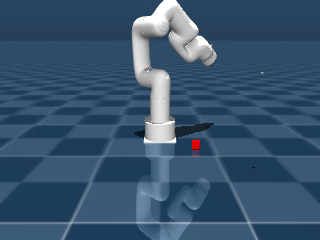

In [2]:
import gym_lite6.env, gym_lite6.pickup_task, gym_lite6.utils
import gymnasium as gym
import numpy as np
import mediapy as media


task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
    visualization_width=320,
    visualization_height=240
)
observation, info = env.reset()
media.show_image(env.render())


In [8]:
import heapq

def dist_metric(x,y):
  """
  L2 norm
  """
  return torch.norm(x-y, dim=1)

def calculate_nearest_neighbours(query, data, k=1, verbose=False):
  t0 = time.time()
  dists = []
  assert len(data[0].shape) == 1, f"Invalid shape, should be 1D: {data.shape}"
  # Takes around 0.25s for 20000 samples
  dists = dist_metric(query, data).cpu()
  heap = [(dists[i].item(), i) for i in range(data.shape[0])]
  
  t1 = time.time()
  heapq.heapify(heap)
  t2 = time.time()

  out = []
  for i in range(k):
    out.append(heapq.heappop(heap))
  
  if verbose:
    print(f"Times: get dists: {t1-t0}, heapify: {t2-t1}")
  return out
        
def calculate_action(dists, dataset, key='action.qpos'):
  """
  Local weighting
  """
  if len(dists) > 1:
    softmin = torch.nn.Softmin(dim=0)
    top_k_weights = softmin(torch.tensor([d[0] for d in dists])).tolist()
    action = sum([top_k_weights[i] * dataset[dists[i][1]][key] for i in range(len(dists))])
  else:
    action = dataset[dists[0][1]][key]

  return action

In [72]:
observation, info = env.reset()
k=3
frames = []
nn_frames = [[] for _ in range(k)]
action = {}
ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

vector_data = dataset["observation.vector.side"]

step = 0
done = False
net.eval()
while step < 10:

  t0 = time.time()
  image_side = (torch.from_numpy(observation["pixels"]["side"]).permute(2, 0, 1).unsqueeze(0) / 255).to(device)
  # image_gripper = torch.from_numpy(observation["pixels"]["gripper"]).permute(2, 0, 1).unsqueeze(0) / 255

  with torch.inference_mode():
    embedding_side = net(image_side).squeeze().cpu()
    # embedding_gripper = net(image_side, image_gripper).to("cpu")
  t1 = time.time()
  
  nn = calculate_nearest_neighbours(embedding_side, vector_data, k=k)

  t2 = time.time()

  # Save the nearest image in the dataset for comparison
  stacked_frame = np.hstack([observation["pixels"]["side"]] + [dataset[nn[i][1]]["observation.pixels.side"].permute(1, 2, 0).numpy() for i in range(k)])
  frames.append(stacked_frame)

  action["qpos"] = calculate_action(nn, dataset, key='action.qpos').numpy()
  action["gripper"] = round(calculate_action(nn, dataset, key='action.gripper').item())

  
  ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
  ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
  ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
  ep_dict["timestamp"].append(env.unwrapped.data.time)

  # Step through the environment and receive a new observation
  observation, reward, terminated, truncated, info = env.step(action)
  
  # ep_dict["observation.pixels.side"].append(observation["pixels"]["side"])
  # ep_dict["observation.pixels.gripper"].append(observation["pixels"]["gripper"])
  ep_dict["reward"].append(reward)
  ep_dict["action.qpos"].append(action["qpos"])
  ep_dict["action.gripper"].append(action["gripper"])
  # ep_dict["frame_index"].append(step)
  # action = calculate_action(nn, key='observation.state.qvel')
    
  done = truncated | done | terminated
  step += 1

  print(f"Timing: inference: {t1-t0}, nn: {t2-t1}, rest: {time.time()-t2}")


ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
ep_dict["timestamp"].append(env.unwrapped.data.time)

# Append dummy nans to the actions so we have the same number of samples can plot it
ep_dict["action.qpos"].append(np.array([np.nan] * len(action["qpos"])))
ep_dict["action.gripper"].append(np.array([np.nan]))
ep_dict["reward"].append(np.array([np.nan]))

avg_reward = sum(ep_dict["reward"])/len(ep_dict["reward"])
print(f"Avg reward: {avg_reward}")
media.show_video(frames)



Timing: inference: 0.015089273452758789, nn: 0.2236642837524414, rest: 0.0768735408782959
Timing: inference: 0.013260364532470703, nn: 0.22830963134765625, rest: 0.07997250556945801
Timing: inference: 0.013757705688476562, nn: 0.21290946006774902, rest: 0.0769040584564209
Timing: inference: 0.013015508651733398, nn: 0.21893620491027832, rest: 0.07462954521179199
Timing: inference: 0.013301849365234375, nn: 0.2575671672821045, rest: 0.0712587833404541
Timing: inference: 0.013035297393798828, nn: 0.25656890869140625, rest: 0.07240700721740723
Timing: inference: 0.012974977493286133, nn: 0.25951290130615234, rest: 0.08056330680847168
Timing: inference: 0.013031959533691406, nn: 0.2475440502166748, rest: 0.07115602493286133
Timing: inference: 0.013065814971923828, nn: 0.26212477684020996, rest: 0.0715937614440918
Timing: inference: 0.013059616088867188, nn: 0.21491575241088867, rest: 0.07859945297241211
Avg reward: 0.0


In [69]:
np.array([np.nan] * len(action["gripper"]))

TypeError: object of type 'int' has no len()

In [71]:
action["gripper"]

0

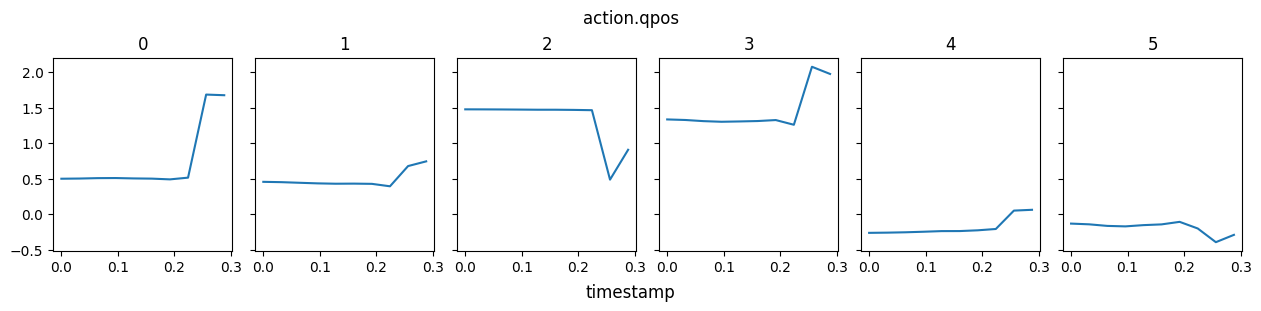

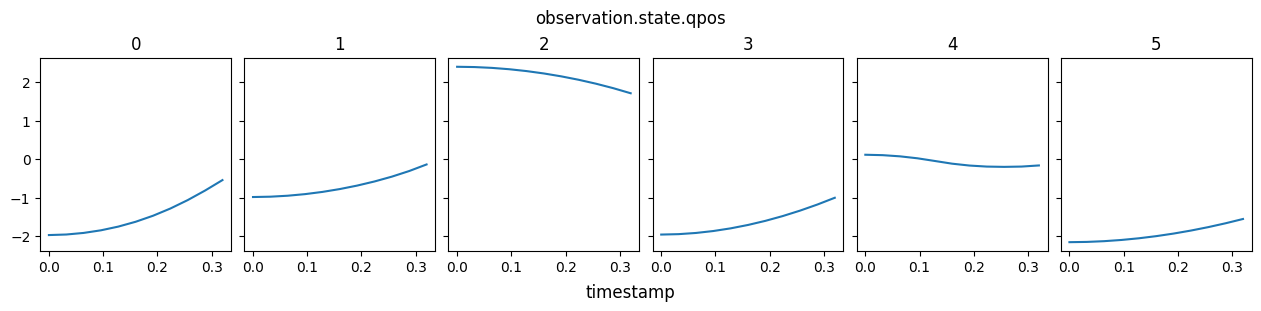

In [73]:
gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", keys=["action.qpos", "observation.state.qpos"], sharey=True)

In [61]:
from importlib import reload
reload(gym_lite6.utils)

<module 'gym_lite6.utils' from '/media/ssd/eugene/robotic_manipulation/gym_lite6/gym_lite6/utils.py'>

In [66]:
ep_dict["action.qpos"]

[array([3.0769458 , 0.09055927, 0.9459818 , 1.9054234 , 0.2679166 ,
        0.9901282 ], dtype=float32),
 array([3.0603452 , 0.3174402 , 0.73634744, 0.9797899 , 0.30837324,
        1.2682024 ], dtype=float32),
 array([3.0585997 , 0.31722587, 0.7363963 , 0.97813684, 0.30870402,
        1.2674724 ], dtype=float32),
 array([3.0412447 , 0.31509423, 0.7368822 , 0.96169937, 0.31199297,
        1.2602128 ], dtype=float32),
 array([ 2.4467955 ,  0.690079  ,  1.3661168 ,  1.5004903 , -0.48050147,
         1.2620457 ], dtype=float32),
 array([2.4702337 , 0.6833403 , 0.8808255 , 1.5817937 , 0.10144697,
        0.9001823 ], dtype=float32),
 array([ 0.8739985 ,  0.9362541 ,  1.1025528 ,  1.5519723 ,  0.10136903,
        -0.67789155], dtype=float32),
 array([-0.17098844,  0.72535574,  0.38765055,  1.5892053 ,  0.14121425,
        -1.7602388 ], dtype=float32),
 array([ 0.92070913,  0.04122637,  1.4493797 ,  0.33314568, -0.12706661,
        -1.7072009 ], dtype=float32),
 array([ 0.51780397,  0.8320368

In [65]:
len(ep_dict["timestamp"])

11

In [60]:
dataset[nn[0][1]]
len(nn)

1

In [ ]:
numpy_observation, info = env.reset()

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []
action = {}

# Render frame of the initial state
frames.append(env.render())

step = 0
done = False
while not done:
  # Prepare observation for the policy running in Pytorch
  # Get qpos in range (-1, 1), gripper is already in range (-1, 1)
  qpos = torch.from_numpy(numpy_observation["state"]["qpos"]).unsqueeze(0)
  gripper = numpy_observation["state"]["gripper"]
  state = torch.hstack((qpos, gripper))
  image_side = torch.from_numpy(numpy_observation["pixels"]["side"]).permute(2, 0, 1).unsqueeze(0) / 255
  image_gripper = torch.from_numpy(numpy_observation["pixels"]["gripper"]).permute(2, 0, 1).unsqueeze(0) / 255
  
  # Convert to float32 with image from channel first in [0,255]
  # to channel last in [0,1]
  state = state.to(torch.float32)

  # Send data tensors from CPU to GPU
  state = state.to(self.params["device"], non_blocking=True)
  image_side = image_side.to(self.params["device"], non_blocking=True)
  image_gripper = image_gripper.to(self.params["device"], non_blocking=True)

  # Predict the next action with respect to the current observation
  with torch.inference_mode():
    raw_action = policy.predict(state, image_side, image_gripper).to("cpu")
  
  action["qpos"] = raw_action[:, :6]
  if self.params["normalize_qpos"]:
    action["qpos"] = self.unnormalize_qpos(action["qpos"])
  
  action["qpos"] = action["qpos"].flatten().numpy()
  action["gripper"] = self.decode_gripper(raw_action[:, 6:8]).item()

  # Step through the environment and receive a new observation
  numpy_observation, reward, terminated, truncated, info = env.step(action)
  # Keep track of all the rewards and frames
  rewards.append(reward)
  frames.append(env.render())

  # Normally we would exit on terminated = True, but we want our evaluation to continue
  # so it can collect the full reward
  done = truncated | done
  step += 1

avg_reward += sum(rewards)/len(rewards)/n